In [1]:
# core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
import torch.nn as nn

# functional
import pickle
from itertools import product
from functools import partial
from torch.multiprocessing import Pool, Manager, set_start_method

# custom
from scripts.functions import tune_rnn

# warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
try:
    set_start_method('spawn')
except RuntimeError as e:
    print("The start method has already been set.")

## Load in Data and Model

In [3]:
data_names = ['tfidf_train', 'tfidf_test', 'y_train_binary', 'y_test_binary']

for var_name in data_names:
    with open(f'data/{var_name}.pkl', 'rb') as f:
        globals()[var_name] = pickle.load(f)

In [4]:
rnn_tfidf = torch.load('models/rnn_binary_tfidf.pth')

## Hyperparameter Tuning

In [5]:
Adam = torch.optim.Adam
SGD = torch.optim.SGD
RMSprop = torch.optim.RMSprop

hp_space = {
    '0_hidden_size': [50, 100, 150],
    '1_num_layers': [1, 2, 3],
    '2_dropout': [0, 0.25, 0.5],
    '3_batch_size': [64, 128, 256],
    '4_optimizer': [Adam, SGD, RMSprop],
    '5_learning_rate': [0.001, 0.01, 0.1]
}

hp_combos = list(product(*hp_space.values())) # [0:2]

len(hp_combos)

729

In [6]:
tune_rnn_accuracy = partial(
    tune_rnn, 
    X_train = tfidf_train, X_test = tfidf_test, 
    y_train = y_train_binary.unsqueeze(1), 
    y_test = y_test_binary.unsqueeze(1), 
    metric = accuracy_score
)

tune_rnn_precision = partial(
    tune_rnn, 
    X_train = tfidf_train, X_test = tfidf_test, 
    y_train = y_train_binary.unsqueeze(1), 
    y_test = y_test_binary.unsqueeze(1), 
    metric = precision_score
)

tune_rnn_recall = partial(
    tune_rnn, 
    X_train = tfidf_train, X_test = tfidf_test, 
    y_train = y_train_binary.unsqueeze(1), 
    y_test = y_test_binary.unsqueeze(1), 
    metric = recall_score
)

tune_rnn_f1 = partial(
    tune_rnn, 
    X_train = tfidf_train, X_test = tfidf_test, 
    y_train = y_train_binary.unsqueeze(1), 
    y_test = y_test_binary.unsqueeze(1), 
    metric = f1_score
)

In [7]:
with Pool(processes = 12) as pool:
    results_accuracy = pool.map(tune_rnn_accuracy, hp_combos)

best_result_idx = results_accuracy.index(max(results_accuracy))
best_hps_accuracy = hp_combos[best_result_idx]
best_hps_accuracy = dict(zip(hp_space.keys(), best_hps_accuracy))

best_hps_accuracy

{'0_hidden_size': 100,
 '1_num_layers': 3,
 '2_dropout': 0.5,
 '3_batch_size': 64,
 '4_optimizer': torch.optim.sgd.SGD,
 '5_learning_rate': 0.1}

In [8]:
with Pool(processes = 12) as pool:
    results_precision = pool.map(tune_rnn_precision, hp_combos)

best_result_idx = results_precision.index(max(results_precision))
best_hps_precision = hp_combos[best_result_idx]
best_hps_precision = dict(zip(hp_space.keys(), best_hps_precision))

best_hps_precision

{'0_hidden_size': 100,
 '1_num_layers': 3,
 '2_dropout': 0.25,
 '3_batch_size': 128,
 '4_optimizer': torch.optim.sgd.SGD,
 '5_learning_rate': 0.1}

In [9]:
with Pool(processes = 12) as pool:
    results_recall = pool.map(tune_rnn_recall, hp_combos)

best_result_idx = results_recall.index(max(results_recall))
best_hps_recall = hp_combos[best_result_idx]
best_hps_recall = dict(zip(hp_space.keys(), best_hps_recall))

best_hps_recall

{'0_hidden_size': 50,
 '1_num_layers': 3,
 '2_dropout': 0,
 '3_batch_size': 64,
 '4_optimizer': torch.optim.rmsprop.RMSprop,
 '5_learning_rate': 0.1}

In [10]:
with Pool(processes = 12) as pool:
    results_f1 = pool.map(tune_rnn_f1, hp_combos)

best_result_idx = results_f1.index(max(results_f1))
best_hps_f1 = hp_combos[best_result_idx]
best_hps_f1 = dict(zip(hp_space.keys(), best_hps_f1))

best_hps_f1

{'0_hidden_size': 100,
 '1_num_layers': 3,
 '2_dropout': 0,
 '3_batch_size': 64,
 '4_optimizer': torch.optim.adam.Adam,
 '5_learning_rate': 0.1}

In [11]:
best_hps = [best_hps_accuracy, best_hps_precision, best_hps_recall, best_hps_f1]
results = [results_accuracy, results_precision, results_recall, results_f1]
metrics = ['accuracy', 'precision', 'recall', 'f1']

for result, metric in zip(results, metrics):
    with open(f'data/hp_result_{metric}.pkl', 'wb') as f:
        pickle.dump(result, f)

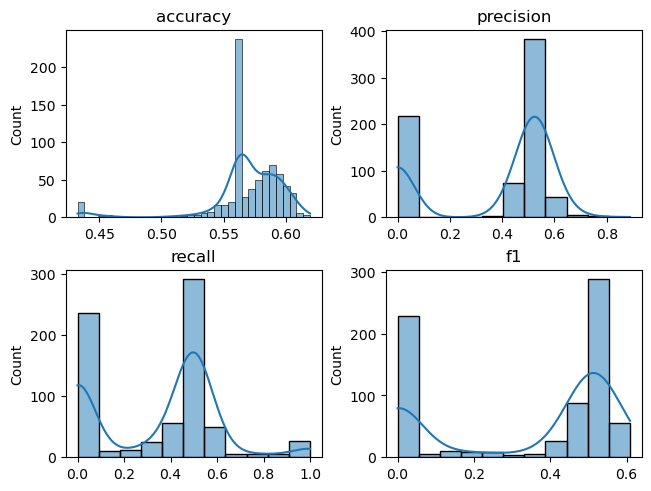

In [12]:
fig, axes = plt.subplots(2, 2, layout = 'constrained')

for result, metric, ax in zip(results, metrics, axes.ravel()):
    sns.histplot(result, ax = ax, kde = True)
    ax.set_title(metric)

plt.show()

In [27]:
results_df = pd.DataFrame(hp_combos, columns = hp_space.keys())

for result, metric in zip(results, metrics):
    results_df[metric] = result

results_df['4_optimizer'] = results_df['4_optimizer'].apply(lambda x: x.__name__)

results_df

,0_hidden_size,1_num_layers,2_dropout,3_batch_size,4_optimizer,5_learning_rate,accuracy,precision,recall,f1
0,50,1,0.0,64,Adam,0.001,0.595896,0.545073,0.540687,0.508920
1,50,1,0.0,64,Adam,0.010,0.587214,0.519862,0.504521,0.487660
2,50,1,0.0,64,Adam,0.100,0.574586,0.499151,0.535262,0.505872
3,50,1,0.0,64,SGD,0.001,0.563536,0.000000,0.000000,0.000000
4,50,1,0.0,64,SGD,0.010,0.563536,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
724,150,3,0.5,256,SGD,0.010,0.563536,0.000000,0.000000,0.000000
725,150,3,0.5,256,SGD,0.100,0.563536,0.000000,0.000000,0.000000
726,150,3,0.5,256,RMSprop,0.001,0.576164,0.533582,0.466546,0.518173
727,150,3,0.5,256,RMSprop,0.010,0.557222,0.522863,0.412297,0.260255


------------accuracy------------


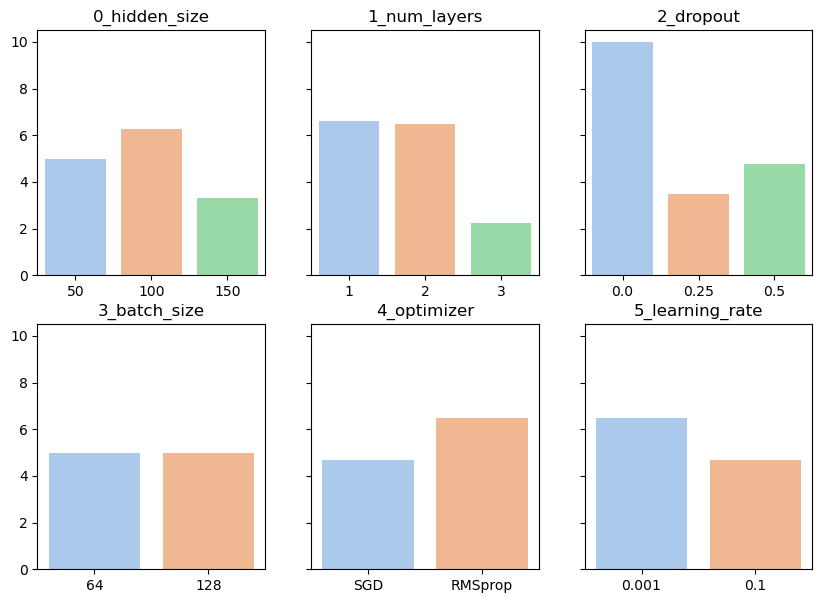






------------precision------------


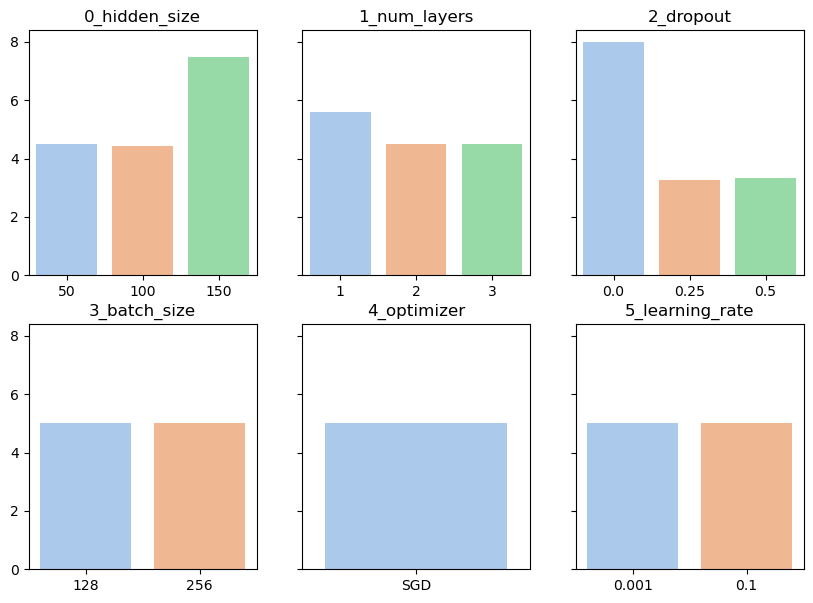






------------recall------------


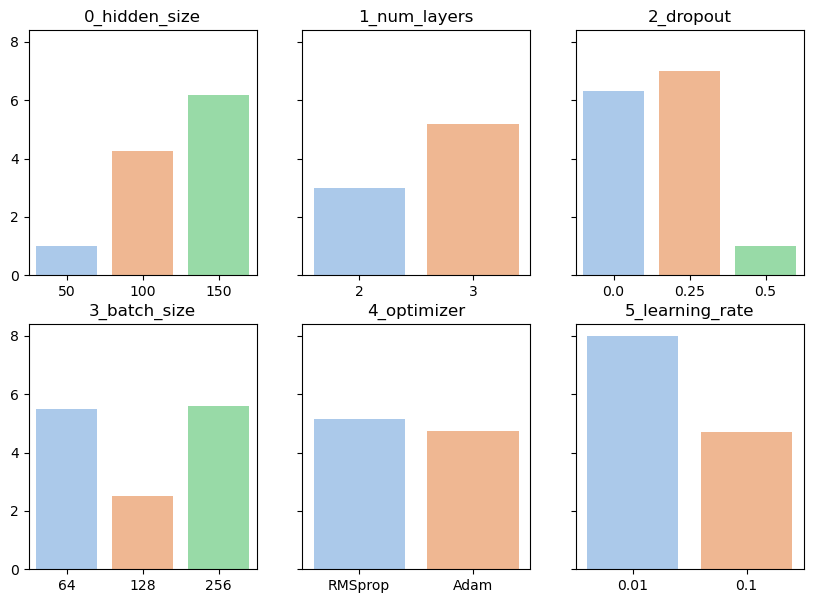






------------f1------------


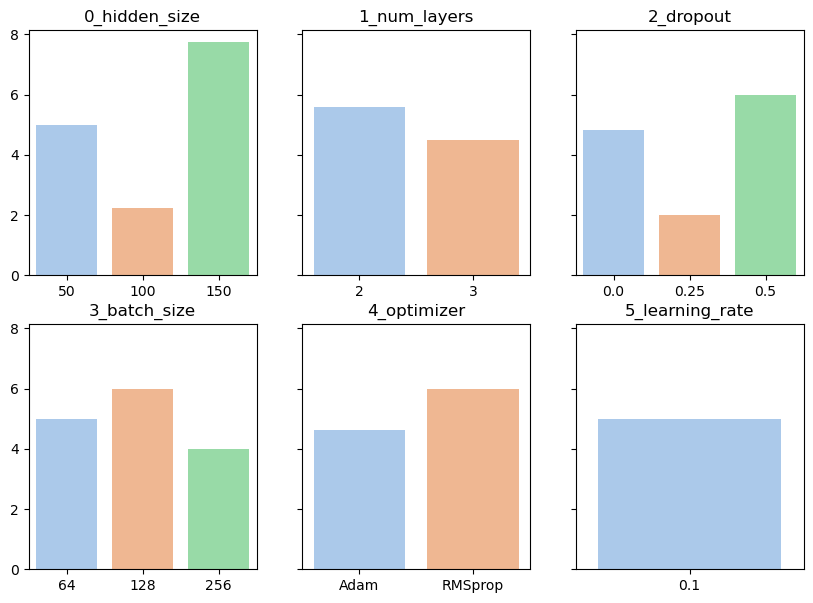

In [56]:
for metric in metrics:
    top10 = results_df.sort_values(by = metric, ascending = False, ignore_index = True).iloc[0:11,:]
    print(f'------------{metric}------------')
    fig, axes = plt.subplots(2, 3, figsize = (10, 7), sharey = True)
    for hp, ax in zip(hp_space.keys(), axes.ravel()):
        sns.barplot(
            x = top10[hp], y = top10.index, ax = ax,
            errorbar = None, palette = 'pastel'
        )
        ax.set_title(hp)
        ax.set_xlabel('')
    plt.show()
    print(f'\n\n\n\n')